# Part 1: Setup and 1D Grid for Schrödinger Equation

## Introduction

The **Schrödinger equation** is the fundamental equation of quantum mechanics:

$$\hat{H}\psi = E\psi$$

where:
- $\hat{H}$ is the **Hamiltonian operator** (total energy)
- $\psi$ is the **wavefunction** (describes quantum state)
- $E$ is the **energy eigenvalue**

### The Hamiltonian

In 1D, the Hamiltonian consists of kinetic and potential energy:

$$\hat{H} = \hat{T} + \hat{V} = -\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + V(x)$$

### Our Approach: Finite Difference Method

We discretize space into $N$ points and approximate the second derivative:

$$\frac{d^2\psi}{dx^2} \approx \frac{\psi_{i+1} - 2\psi_i + \psi_{i-1}}{\Delta x^2}$$

This converts the differential equation into a **matrix eigenvalue problem**!

In [1]:
# ============================================================
# IMPORT LIBRARIES
# ============================================================
# NumPy: For numerical arrays and linear algebra
# SciPy: For eigenvalue solver (linalg.eigh)
# Matplotlib: For plotting wavefunctions and energies

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Set nice plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Physical Constants

We use **atomic units** for simplicity:
- $\hbar = 1$ (reduced Planck's constant)
- $m = 1$ (electron mass)
- $e = 1$ (electron charge)

This simplifies equations and gives energies in **Hartree** (1 Ha = 27.2 eV)

In [2]:
# ============================================================
# PHYSICAL CONSTANTS (Atomic Units)
# ============================================================

HBAR = 1.0  # Reduced Planck's constant (ℏ)
M = 1.0     # Particle mass (electron mass)

# Note: In atomic units:
# - Length is in Bohr radii (a₀ ≈ 0.529 Å)
# - Energy is in Hartree (1 Ha ≈ 27.2 eV)
# - Time is in ℏ/Ha ≈ 24.2 attoseconds

## Creating the Spatial Grid

We create a uniform 1D grid from $x_{min}$ to $x_{max}$ with $N$ points.

The **grid spacing** is: $\Delta x = \frac{x_{max} - x_{min}}{N - 1}$

More points → smaller $\Delta x$ → better accuracy (but slower computation)

In [3]:
def create_grid(x_min, x_max, N):
    """
    Create a 1D spatial grid for solving the Schrödinger equation.
    
    Parameters:
    -----------
    x_min : float
        Left boundary of the spatial domain
    x_max : float
        Right boundary of the spatial domain
    N : int
        Number of grid points (more = higher accuracy)
        
    Returns:
    --------
    x : ndarray
        Array of grid point positions [x₀, x₁, ..., x_{N-1}]
    dx : float
        Grid spacing Δx
        
    Example:
    --------
    >>> x, dx = create_grid(-5, 5, 100)
    >>> print(f"Grid has {len(x)} points with spacing {dx:.4f}")
    """
    # np.linspace creates N evenly spaced points from x_min to x_max
    x = np.linspace(x_min, x_max, N)
    
    # Grid spacing = distance between adjacent points
    dx = x[1] - x[0]
    
    return x, dx


# Test the function
x_test, dx_test = create_grid(-5, 5, 100)
print(f"Created grid with {len(x_test)} points")
print(f"Range: [{x_test[0]:.2f}, {x_test[-1]:.2f}]")
print(f"Grid spacing Δx = {dx_test:.4f}")

Created grid with 100 points
Range: [-5.00, 5.00]
Grid spacing Δx = 0.1010


## Building the Kinetic Energy Matrix

### The Key Idea

The kinetic energy operator is:
$$\hat{T} = -\frac{\hbar^2}{2m}\frac{d^2}{dx^2}$$

Using the finite difference approximation for the second derivative:
$$\frac{d^2\psi_i}{dx^2} \approx \frac{\psi_{i+1} - 2\psi_i + \psi_{i-1}}{\Delta x^2}$$

This becomes a **tridiagonal matrix**:

$$T = -\frac{\hbar^2}{2m\Delta x^2}\begin{pmatrix} -2 & 1 & 0 & 0 & \cdots \\ 1 & -2 & 1 & 0 & \cdots \\ 0 & 1 & -2 & 1 & \cdots \\ \vdots & & & & \ddots \end{pmatrix}$$

### Physical Meaning
- Diagonal elements (-2): How the wavefunction at point $i$ contributes
- Off-diagonal elements (+1): Coupling between neighboring points

In [4]:
def build_kinetic(N, dx, hbar=HBAR, m=M):
    """
    Build the kinetic energy matrix using the finite difference method.
    
    This function constructs an N×N tridiagonal matrix that represents
    the kinetic energy operator T = -ℏ²/(2m) d²/dx² on a discrete grid.
    
    Parameters:
    -----------
    N : int
        Number of grid points (matrix will be N×N)
    dx : float
        Grid spacing (smaller = more accurate but larger matrix)
    hbar : float, optional
        Reduced Planck's constant (default: 1 in atomic units)
    m : float, optional
        Particle mass (default: 1 in atomic units)
        
    Returns:
    --------
    T : ndarray
        N×N kinetic energy matrix (symmetric, tridiagonal)
        
    Notes:
    ------
    The matrix has the structure:
    - Main diagonal: -2 × coefficient
    - Off-diagonals: +1 × coefficient
    where coefficient = -ℏ²/(2m·Δx²)
    """
    # Coefficient from kinetic energy formula
    # Note: The negative signs combine to give positive kinetic energy
    coeff = -hbar**2 / (2 * m * dx**2)
    
    # Create diagonal arrays
    # Main diagonal: N elements, all equal to -2
    main_diag = -2 * np.ones(N)
    
    # Off-diagonals: N-1 elements, all equal to +1
    off_diag = np.ones(N - 1)
    
    # Build the full matrix using np.diag
    # np.diag(v, k) creates a matrix with v on the k-th diagonal
    # k=0: main diagonal, k=1: first super-diagonal, k=-1: first sub-diagonal
    T = coeff * (
        np.diag(main_diag, 0) +    # Main diagonal (-2's)
        np.diag(off_diag, 1) +     # Upper diagonal (+1's)
        np.diag(off_diag, -1)      # Lower diagonal (+1's)
    )
    
    return T

Kinetic matrix shape: (10, 10)
Matrix is symmetric: True

Matrix structure (first 6×6 block):
[[ 0.81  -0.405 -0.    -0.    -0.    -0.   ]
 [-0.405  0.81  -0.405 -0.    -0.    -0.   ]
 [-0.    -0.405  0.81  -0.405 -0.    -0.   ]
 [-0.    -0.    -0.405  0.81  -0.405 -0.   ]
 [-0.    -0.    -0.    -0.405  0.81  -0.405]
 [-0.    -0.    -0.    -0.    -0.405  0.81 ]]


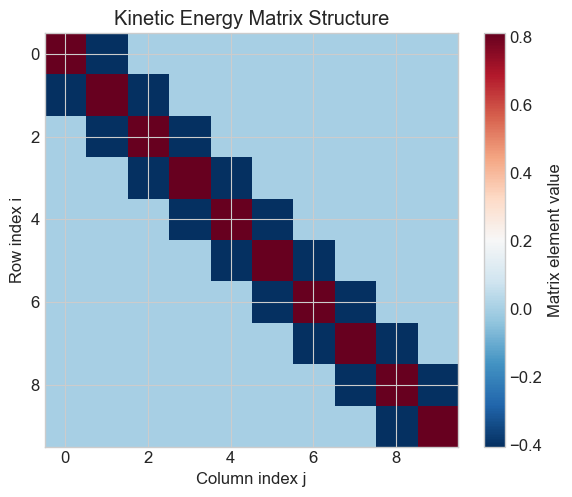

In [5]:
# Test and visualize the kinetic matrix
N_test = 10
x, dx = create_grid(-5, 5, N_test)
T = build_kinetic(N_test, dx)

print(f"Kinetic matrix shape: {T.shape}")
print(f"Matrix is symmetric: {np.allclose(T, T.T)}")
print(f"\nMatrix structure (first 6×6 block):")
print(np.round(T[:6, :6], 3))

# Visualize the matrix structure
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(T, cmap='RdBu_r')
ax.set_title('Kinetic Energy Matrix Structure')
ax.set_xlabel('Column index j')
ax.set_ylabel('Row index i')
plt.colorbar(im, label='Matrix element value')
plt.tight_layout()
plt.show()

## Summary

We now have the two essential building blocks:

1. **`create_grid(x_min, x_max, N)`** - Creates the spatial discretization
2. **`build_kinetic(N, dx)`** - Builds the kinetic energy matrix $T$

### Next Steps
In the next notebook, we'll:
- Add potential energy $V(x)$ to get the full Hamiltonian $H = T + V$
- Solve the eigenvalue problem to find energy levels and wavefunctions
- Start with the harmonic oscillator as our first example